# Regression Analysis

** NEED TO SET UP TRAIN / VAL SPLIT **

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data Import and Setup

In [2]:
sf = pd.read_csv('data_files/sf_clean.csv')

# Reformatting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

### Dropping Price Threshhold (6k)

In [3]:
sf = sf[sf['price'] < 6000]

In [4]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 1 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          936 non-null    int64  
 1   sqft           936 non-null    float64
 2   beds           936 non-null    float64
 3   bath           936 non-null    float64
 4   laundry        936 non-null    object 
 5   pets           936 non-null    object 
 6   housing_type   936 non-null    object 
 7   parking        936 non-null    object 
 8   hood_district  936 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 73.1+ KB


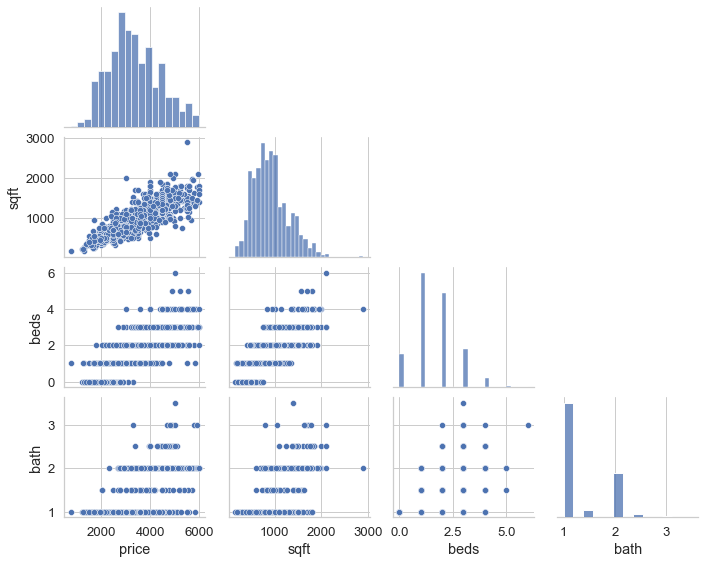

In [5]:
sns.pairplot(sf, height=2, aspect=1.25, corner=True);

### Dropping Features

In [6]:
sf = sf.drop(['pets'], axis=1)
sf = sf.drop(['housing_type'], axis=1)

### Dummy variables

In [7]:
sf = pd.get_dummies(sf)

In [8]:
cols_to_drop = ['laundry_(c) no laundry',
               #'laundry_(b) on-site',
               #'pets_(d) no pets', 
               #'housing_type_(c) multi', 
               'parking_(d) no parking',
               'hood_district_10']

sf = sf.drop(cols_to_drop, axis=1)

## Train/Test Splits

In [9]:
X, y = sf.drop('price',axis=1), sf['price']

# Training versus Test Data
# hold out 30% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=4)

In [10]:
# Scaling for Ridge & Lasso 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

## Linear

In [11]:
# restructuring X, y for kfolds
X_kf, y_kf = np.array(X), np.array(y)


kf = KFold(n_splits=3, shuffle=True, random_state = 42)
cv_lin_r2s = []
rmses = []

for train_ind, val_ind in kf.split(X_kf, y_kf):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    lin = LinearRegression()
    
    lin.fit(X_train, y_train)
    cv_lin_r2s.append(lin.score(X_val, y_val))
    
    lin_rmse = mean_squared_error(y_val, lin.predict(X_val), squared=False)
    rmses.append(lin_rmse)
    
    
print('Simple regression scores: ', cv_lin_r2s)
print(f'Simple mean cv r^2: {np.mean(cv_lin_r2s):.3f} +- {np.std(cv_lin_r2s):.3f}')
print(f'Simple mean RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')

Simple regression scores:  [0.7566005237955266, 0.8069399731370696, 0.724779362419623]
Simple mean cv r^2: 0.763 +- 0.034
Simple mean RMSE: 496.678 +- 44.773


In [12]:
lin = LinearRegression()

lin.fit(X, y)
print(f'Linear Regression train R^2: {lin.score(X, y):.5f}')
print(f'Linear Regression val R^2: {lin.score(X_test, y_test):.5f}')

Linear Regression train R^2: 0.77526
Linear Regression val R^2: 0.77048


In [13]:
lin_predict = lin.predict(X_test)

lin_rmse = mean_squared_error(y_test, lin_predict, squared=False)
lin_rmse

510.64231313850445

## Lasso

### Cross Validation 

In [14]:
alphavec = 10**np.linspace(-2,1,100)

lasso_model = LassoCV(alphas = alphavec, cv=3)
lasso_model.fit(X_train_scaled, y)

LassoCV(alphas=array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722368,  0.06135907,  0.06579332,  0.07054802,  0.07564633,
        0.081...
        0.93260335,  1.        ,  1.07226722,  1.149757  ,  1.23284674,
        1.32194115,  1.41747416,  1.51991108,  1.62975083,  1.7475284 ,
        1.87381742,  2.009233  ,  2.15443469,  2.3101297 ,  2.47707636,
        2.65608778,  2.84803587,  3.05385551,  3.27454916,  3.51119173,
        3.76493581,  4.03701726,  4.32876128,  4.64158883,  4.97702356,
        5.33669923,  5.72236766,  6.13590727,  6.57933225,  7.05480231,
        7.56463328,  8.11130831,  8.69749003,  9.32603347, 10.        ]),
        cv=3)

In [15]:
las_alpha = lasso_model.alpha_
las_alpha

0.01

### Model Scoring

In [16]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y)
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y):.5f}')
print(f'Lasso Regression test R^2: {las.score(X_test_scaled, y_test):.5f}')

Lasso Regression train R^2: 0.77526
Lasso Regression test R^2: 0.77048


## Ridge

### Cross Validation

In [17]:
alphavec = 10**np.linspace(-2,1,100)

ridge_model = RidgeCV(alphas = alphavec, cv=3)
ridge_model.fit(X_train_scaled, y)

RidgeCV(alphas=array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722368,  0.06135907,  0.06579332,  0.07054802,  0.07564633,
        0.081...
        0.93260335,  1.        ,  1.07226722,  1.149757  ,  1.23284674,
        1.32194115,  1.41747416,  1.51991108,  1.62975083,  1.7475284 ,
        1.87381742,  2.009233  ,  2.15443469,  2.3101297 ,  2.47707636,
        2.65608778,  2.84803587,  3.05385551,  3.27454916,  3.51119173,
        3.76493581,  4.03701726,  4.32876128,  4.64158883,  4.97702356,
        5.33669923,  5.72236766,  6.13590727,  6.57933225,  7.05480231,
        7.56463328,  8.11130831,  8.69749003,  9.32603347, 10.        ]),
        cv=3)

In [18]:
rid_alpha = ridge_model.alpha_
rid_alpha

0.43287612810830595

### Model Scoring

In [19]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y):.5f}')
print(f'Ridge Regression test R^2: {rid.score(X_test_scaled, y_test):.5f}')

Ridge Regression train R^2: 0.77526
Ridge Regression test R^2: 0.77041


## Evaluation

### Cross validation using KFolds

In [20]:
sf2 = sf.copy()

In [21]:
X, y = sf2.drop('price',axis=1), sf2['price']

# Training versus Test Data
# hold out 30% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=6)

In [22]:
# restructuring X, y for kfolds
X_kf, y_kf = np.array(X), np.array(y)

kf = KFold(n_splits=3, shuffle=True, random_state = 37)

# r2s 
cv_lin_val_r2s, cv_rid_val_r2s, cv_las_val_r2s = [], [], []

# RMSEs
lin_rmses, rid_rmses, las_rmses = [], [], []

# Cross Validation Workflow
for train_ind, val_ind in kf.split(X_kf, y_kf):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
       
    # Simple linear Regression
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    cv_lin_val_r2s.append(lin.score(X_val, y_val))
    lin_rmses.append(mean_squared_error(y_val, lin.predict(X_val), squared=False))
    
    # Feature scaling for ridge & lasso
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Ridge
    rid = Ridge(alpha=rid_alpha)
    rid.fit(X_train_scaled, y_train)
    cv_rid_val_r2s.append(rid.score(X_val_scaled, y_val))
    rid_rmses.append(mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False))
    
    # Lasso
    las = Lasso(alpha=las_alpha)
    las.fit(X_train_scaled, y_train)
    cv_las_val_r2s.append(las.score(X_val_scaled, y_val))
    las_rmses.append(mean_squared_error(y_val, las.predict(X_val_scaled), squared=False))

    
# Summary Output
print('Simple regression scores: ', cv_lin_val_r2s)
print(f'Simple mean cv r^2: {np.mean(cv_lin_val_r2s):.5f} +- {np.std(cv_lin_val_r2s):.5f}')
print(f'Simple mean RMSE: {np.mean(lin_rmses):.3f} +- {np.std(lin_rmses):.3f}')
print('')
print('Ridge regression scores: ', cv_rid_val_r2s)
print(f'Ridge mean cv r^2: {np.mean(cv_rid_val_r2s):.5f} +- {np.std(cv_rid_val_r2s):.5f}')
print(f'Ridge mean RMSE: {np.mean(rid_rmses):.5f} +- {np.std(rid_rmses):.3f}')
print('')
print('Lasso regression scores: ', cv_las_r2s)
print(f'Lasso mean cv r^2: {np.mean(cv_las_val_r2s):.5f} +- {np.std(cv_las_val_r2s):.5f}')
print(f'Lasso mean RMSE: {np.mean(las_rmses):.5f} +- {np.std(las_rmses):.5f}')

Simple regression scores:  [0.7441201742914527, 0.7246129085130093, 0.7666877173669617]
Simple mean cv r^2: 0.74514 +- 0.01719
Simple mean RMSE: 505.196 +- 22.231

Ridge regression scores:  [0.7439242723026809, 0.7249483148571415, 0.7667065542663445]
Ridge mean cv r^2: 0.74519 +- 0.01707
Ridge mean RMSE: 505.14315 +- 22.060



NameError: name 'cv_las_r2s' is not defined

### Linear

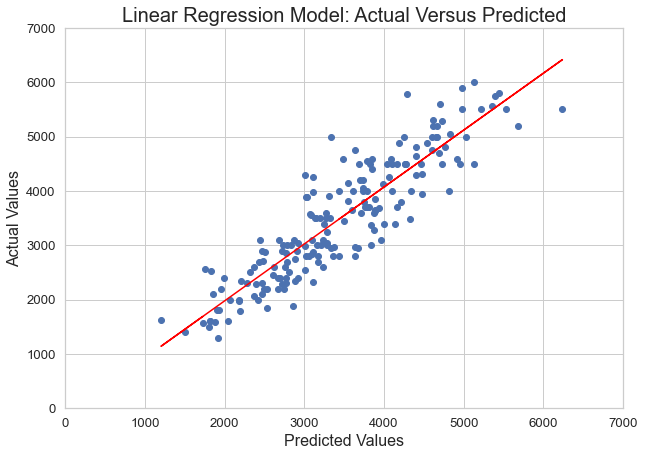

In [23]:
lin_predict = lin.predict(X_test)

plt.figure(figsize=(10, 7))
plt.scatter(lin_predict, y_test) 

z = np.polyfit(lin_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lin_predict, p(lin_predict), 'm-', color='red')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.title('Linear Regression Model: Actual Versus Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16);

In [24]:
lin_residual = (y_test - lin_predict)

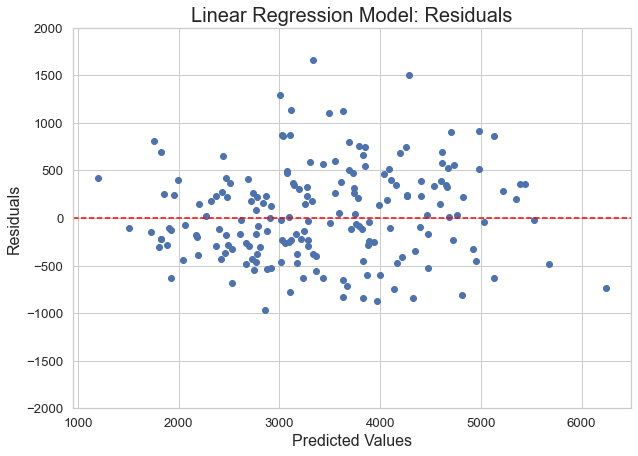

In [27]:
plt.figure(figsize=(10, 7))
plt.scatter(lin_predict, lin_residual)    #change this if working with sklearn

plt.axhline(0, linestyle='--', color='red')
plt.title('Linear Regression Model: Residuals', fontsize=20)
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Residuals', fontsize=16);

In [ ]:
# HOMOscedasticity

### Ridge

In [ ]:
rid_predict = rid.predict(X_test_scaled)

mean_squared_error(y_test, rid_predict, squared=False)

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(rid_predict, y_test) 

z = np.polyfit(rid_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(rid_predict, p(rid_predict), 'm-')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.title('Ridge Regression Model: Actual Versus Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16);

### Lasso

In [ ]:
las_predict = las.predict(X_test_scaled)

mean_squared_error(y_test, las_predict, squared=False)

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(las_predict, y_test) 

z = np.polyfit(las_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(las_predict, p(las_predict), 'm-')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.title('Lasso Regression Model: Actual Versus Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16);

### Coefficients

In [ ]:
lin_coefs = lin.coef_
rid_coefs = rid.coef_
las_coefs = las.coef_

features = sf.columns[1:]

coef_data = {'Features': features,
             'Linear': lin_coefs,
             'Ridge': rid_coefs,
             'Lasso': las_coefs}

coef_df = pd.DataFrame(coef_data)
coef_df

### OUTPUT 

In [ ]:
# Linear
print(f'Linear Regression train R^2: {lin.score(X, y):.5f}')
print(f'Linear Regression val R^2: {lin.score(X_test, y_test):.5f}')
print(mean_squared_error(y_test, lin_predict, squared=False))
print("")

# Lasso
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y):.5f}')
print(f'Lasso Regression test R^2: {las.score(X_test_scaled, y_test):.5f}')
print(mean_squared_error(y_test, las_predict, squared=False))
print("")

# Ridge
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y):.5f}')
print(f'Ridge Regression test R^2: {rid.score(X_test_scaled, y_test):.5f}')
print(mean_squared_error(y_test, rid_predict, squared=False))